In [1]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import sys
import tensorflow as tf
import collections

if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.cliff_walking import CliffWalkingEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = CliffWalkingEnv()

In [3]:
class PolicyEstimator():
    """
    Policy Function approximator. 
    """
    
    def __init__(self, learning_rate=0.01, scope="policy_estimator"):
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.int32, [], "state")
            self.action = tf.placeholder(dtype=tf.int32, name="action")
            self.target = tf.placeholder(dtype=tf.float32, name="target")

            # This is just table lookup estimator
            state_one_hot = tf.one_hot(self.state, int(env.observation_space.n))
            self.output_layer = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(state_one_hot, 0),
                num_outputs=env.action_space.n,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer())

            self.action_probs = tf.squeeze(tf.nn.softmax(self.output_layer))
            self.picked_action_prob = tf.gather(self.action_probs, self.action)

            # Loss and train op
            self.loss = -tf.log(self.picked_action_prob) * self.target

            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.contrib.framework.get_global_step())
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        return sess.run(self.action_probs, { self.state: state })

    def update(self, state, target, action, sess=None):
        sess = sess or tf.get_default_session()
        feed_dict = { self.state: state, self.target: target, self.action: action  }
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

In [4]:
class ValueEstimator():
    """
    Value Function approximator. 
    """
    
    def __init__(self, learning_rate=0.1, scope="value_estimator"):
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.int32, [], "state")
            self.target = tf.placeholder(dtype=tf.float32, name="target")

            # This is just table lookup estimator
            state_one_hot = tf.one_hot(self.state, int(env.observation_space.n))
            self.output_layer = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(state_one_hot, 0),
                num_outputs=1,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer())

            self.value_estimate = tf.squeeze(self.output_layer)
            self.loss = tf.squared_difference(self.value_estimate, self.target)

            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.contrib.framework.get_global_step())        
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        return sess.run(self.value_estimate, { self.state: state })

    def update(self, state, target, sess=None):
        sess = sess or tf.get_default_session()
        feed_dict = { self.state: state, self.target: target }
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

In [5]:
def actor_critic(env, estimator_policy, estimator_value, num_episodes, discount_factor=1.0):
    """
    Actor Critic Algorithm. Optimizes the policy 
    function approximator using policy gradient.
    
    Args:
        env: OpenAI environment.
        estimator_policy: Policy Function to be optimized 
        estimator_value: Value function approximator, used as a baseline
        num_episodes: Number of episodes to run for
        discount_factor: Time-discount factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    for i_episode in range(num_episodes):
        # episode = []
        
        # Reset the environment
        state = env.reset()
        # Generate an episode
        # I = 1
        for t in itertools.count():
            action_probs = estimator_policy.predict(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)
            # episode.append((state, action, reward))
            
            td_target = reward + discount_factor*estimator_value.predict(next_state)
            td_error = td_target - estimator_value.predict(state)
                
            estimator_value_loss = estimator_value.update(state, td_target)
            # TODO: Have to multiply learning_rate to I:
            estimator_policy_loss = estimator_policy.update(state, td_error, action)
            # I *= discount_factor
               
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            if done:
                break
            state = next_state
            
        # Print out which episode we're on, useful for debugging.
        print("\rStep {} @ Episode {}/{}".format(
            t, i_episode + 1, num_episodes))
    
    return stats

In [6]:
tf.reset_default_graph()

global_step = tf.Variable(0, name="global_step", trainable=False)
policy_estimator = PolicyEstimator()
value_estimator = ValueEstimator()

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    # Note, due to randomness in the policy the number of episodes you need to learn a good
    # policy may vary. ~300 seemed to work well for me.
    stats = actor_critic(env, policy_estimator, value_estimator, 300)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


[2017-04-09 23:43:43,338] From <ipython-input-6-0294ea6b53c4>:8: initialize_all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.global_variables_initializer` instead.


Step 13 @ Episode 1/300
Step 16 @ Episode 2/300
Step 0 @ Episode 3/300
Step 1 @ Episode 4/300
Step 0 @ Episode 5/300
Step 73 @ Episode 6/300
Step 3 @ Episode 7/300
Step 50 @ Episode 8/300
Step 0 @ Episode 9/300
Step 183 @ Episode 10/300
Step 17 @ Episode 11/300
Step 38 @ Episode 12/300
Step 0 @ Episode 13/300
Step 88 @ Episode 14/300
Step 0 @ Episode 15/300
Step 212 @ Episode 16/300
Step 55 @ Episode 17/300
Step 35 @ Episode 18/300
Step 15 @ Episode 19/300
Step 57 @ Episode 20/300
Step 1 @ Episode 21/300
Step 9 @ Episode 22/300
Step 55 @ Episode 23/300
Step 33 @ Episode 24/300
Step 31 @ Episode 25/300
Step 329 @ Episode 26/300
Step 52 @ Episode 27/300
Step 2 @ Episode 28/300
Step 65 @ Episode 29/300
Step 181 @ Episode 30/300
Step 427 @ Episode 31/300
Step 39 @ Episode 32/300
Step 11 @ Episode 33/300
Step 41 @ Episode 34/300
Step 71 @ Episode 35/300
Step 112 @ Episode 36/300
Step 3 @ Episode 37/300
Step 12 @ Episode 38/300
Step 27 @ Episode 39/300
Step 0 @ Episode 40/300
Step 14 @ Episo

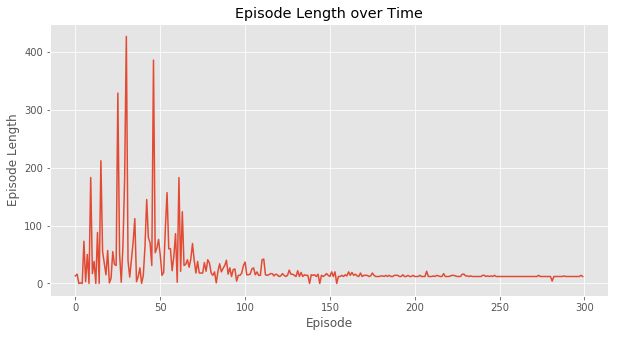

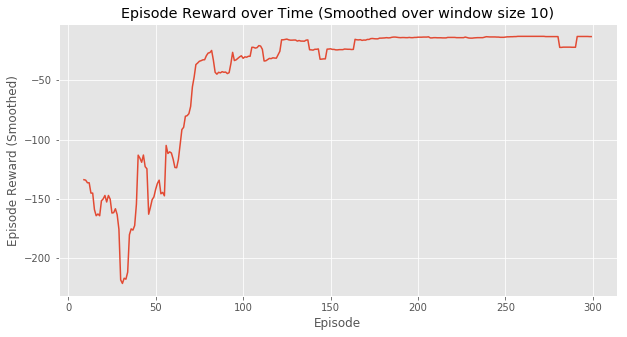

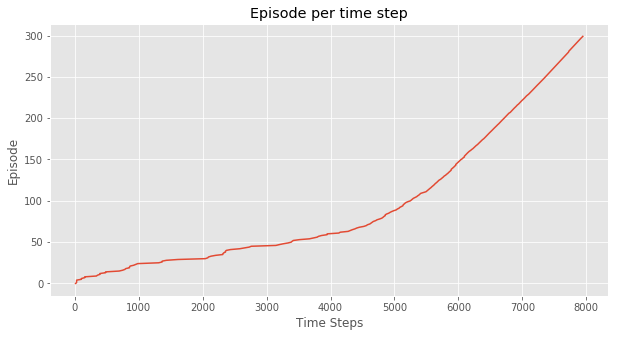

(<matplotlib.figure.Figure at 0x10cead828>,
 <matplotlib.figure.Figure at 0x10f905c18>)

In [7]:
plotting.plot_episode_stats(stats, smoothing_window=10)